Assumptions:
1. User have similar rating in past will have similar rating in future.
2. For computing pearson similarity we consider only the rating which user 1 and user 2 both has value. If either of it is not available like "Nan" value that rating is not considered.
3. The preference of user stays consistent over time.
4. The movie rating for a target user is almost Nan which means only 5-10% we have values. So the missing ratings is first computed.
5. For predicting movie recommendations for a user we need to first predict the missing movie ratings of the user in target with the similar users (top 100 similar users is considered) first and then the ratings are sorted and top 10 is picked up and displayed to the user as top 10 recommended movies for user in target.
6. When a top similiar users doesnt have the movie rating which is considered for prediction then the target users movie rating's mean is returned and stored as the rating for that movie.

Assignment -2
7. For predicting single user top K movies, 100 similar users were considered and top 200 movies are suggested for each user.
8. Each user in a considered group has top 200 movies recommended for them seperately and commonly rated movies by all 3 users in the group is retrieved.
9. These commonly rated movies are then sent to aggregation function such as average and least misery for obtaining combined group recommendation for this specific group.
8. For suggesting the first movie we take both the group recommended list from both the aggregations and sort them by ratings and then first movie in the average list is selected the score for it taken by finding the maximum score for this movie in both the aggregated movie lists.
9. For computing the user satisfaction for each user from their top 200 recommended movies the first top 10 movies is conidered and the ratings for this movies alone are summed and using as the denominator. And for the numerator the group recommended movies are taken and their corresponding rating from the target user recommendation list is taken and summed up.
10. For computing the disagreement "Coefficient of variation" method is used.
11. For recommending the 2nd top movie this disagreement is considered and using the hybrid recommendation formula given in class new movie scores are calculated from the same list of movies which we got from aggregations but excluding the movie that has been be suggested to the group.
12. The above step is repeated for next 9 iterations and top 10 movies are found for the given group.



Running Instruction:
1. u.data, u.item, u.user <- these are the 3 files needed for running this code.
2. Preferrably run the file in colab and have these 3 data files in drive.
3. Cells are in order so it can be run from top to bottom one by one.
4. For selecting users to form a group rather than the test input which is already given, there is a separate K means clustering function from which the users can be picked manually from a single cluster.


In [283]:
#importing necessary libraries
import pandas as pd
import numpy as np
import math

In [284]:
from google.colab import drive
drive.mount('/content/drive')
file_path_u_data = '/content/drive/My Drive/RS/u.data'
file_path_u_user = '/content/drive/My Drive/RS/u.user'
file_path_u_item = '/content/drive/My Drive/RS/u.item'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **part 1  -  Importing data**

In [285]:
#u.data file has all the data needed which is in .data format. This u.data file has 100000 ratings by 943 users on 1682 items.
# structure of data -<  user id | item id | rating | timestamp

#creating meaning full names for each column
column_names=["user_id", "item_id",  "rating", "timestamp"]

#pd.read_table -> uses pandas library to import the u.data files data in a table format. Since the data itself hadnt any header it is specified as "None".
df=pd.read_table(file_path_u_data,header=None,names=column_names)


#to print the top 5 row vales from the data .head() function is used.
df.head()

#len() function is used to print the total number f rows in the dataset which is imported in variable called 'df'.
print("The data has total of",len(df),"rows")

The data has total of 100000 rows


In [286]:
#dropping 'timestamp' column from the data which is not required in this case.
df = df.drop("timestamp", axis=1)

#creating a user-item matrix with user-id's in rows index and item-ids in column and rating in the cell values.
user_item_matrix = df.pivot(index="user_id", columns="item_id", values="rating")

#replacing 0 for Nan values
#user_item_matrix.fillna(0,inplace=True)

#printing first few rows
user_item_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [287]:
col_names = {
    "item": ['movie id' , 'movie title' , 'release date' , 'video release date' ,
              'IMDb URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              "Children's" , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
              'Thriller' , 'War' , 'Western'],
    "user": ['user id' , 'age' , 'gender' , 'occupation' , 'zip code']
}


In [288]:
movies = pd.read_table(file_path_u_item, header = None, sep='|', names = col_names["item"],  encoding='latin-1')
movies.head(5)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [289]:
users = pd.read_table(file_path_u_user, header = None, sep='|', names = col_names["user"],  encoding='utf-8')
users.head(5)

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [290]:
#PEARSON SIMILARITY FUNCTION MANUAL IMPLEMENTATION

def pearson_correlation_computed_function(target_user, user2):
    # Find common items rated by both users
    common_items = (user_item_matrix.loc[target_user].dropna().index).intersection(user_item_matrix.loc[user2].dropna().index)
    if len(common_items) == 0:
        return 0  # No common items, so correlation is 0

    # Extract the ratings for the common items
    #r(a,p)
    user1_ratings = [user_item_matrix.loc[target_user][i] for i in common_items]
    #r(b,p)
    user2_ratings = [user_item_matrix.loc[user2][i] for i in common_items]

    # Calculate the mean ratings for both users
    # mean(r_a)
    mean_user1 = np.mean(user1_ratings)
    #  mean(r_b)
    mean_user2 = np.mean(user2_ratings)

    # Calculate the numerator and denominators for Pearson correlation
    # (Σp[(r(a,p) - mean(r_a)) * (r(b,p) - mean(r_b)]) for every p belongs to set "P" - which has common ratings from target user as well as user in consideration.
    numerator = sum((user1_ratings[i] - mean_user1) * (user2_ratings[i] - mean_user2) for i in range(len(common_items)))
    #  [√(Σ(r(a,p) - mean(r_a)² * √(Σ(r(b,p) - mean(r_b)²)]
    denominator_user1 = np.sqrt(sum((user1_ratings[i] - mean_user1) ** 2 for i in range(len(common_items))))
    denominator_user2 = np.sqrt(sum((user2_ratings[i] - mean_user2) ** 2 for i in range(len(common_items))))

    # Calculate the Pearson correlation coefficient
    if denominator_user1 == 0 or denominator_user2 == 0:
        return 0  # Handle division by zero
    else:
       #pearson correlation = (Σp[(r(a,p) - mean(r_a)) * (r(b,p) - mean(r_b)])/ [√(Σ(r(a,p) - mean(r_a)² * √(Σ(r(b,p) - mean(r_b)²)]
        correlation = numerator / (denominator_user1 * denominator_user2)
        return correlation

#pearson_similarity = pearson_correlation(user1, user2)
#print(f"Pearson Correlation: {pearson_similarity}")


#calls manually defined pearson function iteratively to compute similarity for all the user 942 users exlusing the target user.
#parameter explanation - (target_user) -> user for whom the recommendation is required, (num_users) -> consider num_users as a int n it is like returning top n closely similar user to the user in target.
def find_similar_users_with_compute_pearson(target_user, num_users):
    similarities = {}
    #iterating over each user in the user-item matrix
    for user in user_item_matrix.index:
        #condition to skip when the current user in the iteration is equal to the target user. Since we dont want to compute pearson similarity for a target user user the target user himself.
        if user != target_user:
            #computing similarity for target user eg:Alice with other user eg:user1(increased like user2, user3 till users 943 one by one) using predefined pearson function
            #similarity = pearson_correlation_predefined(target_user, user)
            #computing similarity for target user eg:Alice with other user eg:user1(increased like user2, user3 till users 943 one by one) using formula based computed pearson function
            similarity = pearson_correlation_computed_function(target_user, user)
            #similarities are stored in this array called "similarities" with respect to each user_id as as its index. Eg: similarity[102] gives the similarity value between the target user and the user 102.
            similarities[user] = similarity
    #filtered_similarity = {k: v for k, v in similarities.items() if not isinstance(v, float) or not math.isnan(v)}
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:num_users]

#PREDICTION FUNCTION GIVEN IN CLASS

import math
def prediction_funciton_inclass(targetUser,movie,pearsonResult100,meanRA):
    #defining how many neighbors should be considered for predicting movie rating
    #num_users=100
    #pearsonResult=find_similar_users_with_compute_pearson(targetUser, num_users)

    #similar users and their corresponding similarity values for top 100 users are computed and stored.
    #finding out of these similar users which users has the rated value for movie which the prediction should be done to the target user. Eg: if movie number 101 for the target user needs to be prediction even from the top 100 similar user to the target user is considered entirely. We should implement a filter which filters only the user which has rating for this secific movie.
    similarUsers=[item[0] for item in pearsonResult100]
    similarUserWithRating=[]
    for i in similarUsers:
      if(not math.isnan(user_item_matrix.loc[i][movie])):
        #print(user_item_matrix.loc[i][movie])
        similarUserWithRating.append(i)
    filteredPearsonResult=[]
    for item in pearsonResult100:
      if item[0] in similarUserWithRating:
        filteredPearsonResult.append(item)

    filteredPearsonResultArr = np.array(filteredPearsonResult)
    #if there is ratings for that particular movie with top 100 users then compute the below else return mean of RA
    if filteredPearsonResultArr.size != 0:
        #compute rest of the formula
        numer=0
        denom=0
        #print(filteredPearsonResult)
        #print("predicting movie...",movie)
        for simUser,simAB in filteredPearsonResult:
          common_items = (user_item_matrix.loc[targetUser].dropna().index).intersection(user_item_matrix.loc[simUser].dropna().index)
          if len(common_items) == 0:
              return 0  # No common items, so correlation is 0

          # Extract the ratings for the common items
          #r(b,p)
          rb_ratings = [user_item_matrix.loc[simUser][i] for i in common_items]

          #r_a(mean target user rating)
          ra_ratings = [user_item_matrix.loc[simUser][i] for i in common_items]

          # Calculate the mean ratings for both user
          #  mean(r_b)
          meanRB = np.mean(rb_ratings)

          #curret users movie rating for the speific movie in prediction
          Rbp=user_item_matrix.loc[simUser][movie]

          #computes the numerator part of the given predictor function (sum(sim(a,b)*(rbp-mean(r_b)))
          cal=(simAB*(Rbp-meanRB))
          numer+=cal
          #computes the denominator part of the given predictor function (sum(sim(a,b)))
          denom+=simAB

        #final computation of the predictor function
        #pred(a,p)=mean(r_a)+(sum(sim(a,b)*(rbp-mean(r_b)))/(sum(sim(a,b)))
        return meanRA+(numer/denom)
    else:
      return meanRA








Top 10 Recommended movies

In [291]:
#finding similar movies
from collections import defaultdict
def predict_topmovies_forSingleUser(selectedUser,topMovies,similarUser):
    print("predicting for user",selectedUser)
    user_ratings = user_item_matrix.loc[selectedUser]
    new_movie_recommendations = defaultdict(float)
    similar_users100 = find_similar_users_with_compute_pearson(selectedUser,similarUser)
    #r_a(mean target user rating)
    availableRatingInA=[]
    #filtering out rating in A which is the target user where rating in not "NaN"
    for i in range(1,len(user_item_matrix.loc[selectedUser])):
      if(not math.isnan(user_item_matrix.loc[selectedUser][i])):
        availableRatingInA.append(user_item_matrix.loc[selectedUser][i])
    meanRA=np.mean(availableRatingInA)

    for movie in user_item_matrix.columns:
        if pd.isna(user_ratings[movie]) or user_ratings[movie] == 0:
            predicted_rating = prediction_funciton_inclass(selectedUser, movie,similar_users100,meanRA)
            #predicted rating for the movie considered is stored in movie recommendation variable.
            if predicted_rating>5:
              predicted_rating=5
            else:
              predicted_rating
            new_movie_recommendations[movie] = predicted_rating
        #else:
            #the rating of the movie which the target user already has is also being append to the movie recommendation variable.
            #movie_recommendations[movie] = user_ratings[movie]
    return sorted(new_movie_recommendations.items(), key=lambda x: x[1], reverse=True)[:topMovies]
#print(f"10 most relevant movie recommendations for User :",selectedUser)
#for movie, rating in top_recommendations:
    #print(f"Movie Name: {movies.loc[movie][1]}, Movie ID: {movie}, Predicted Rating: {rating:.2f}, Release Date: {movies.loc[movie][2]}")

In [292]:
# Takes each member from the given group(list of similar user) and predicts top K movies fro each user.
def predict_topMovies_for_users(users):
    topMoviesToConsider=200
    topSimilarUserToConsider=100
    predictedRatings=[0]*len(users)
    i=0
    for user in users:
      predictedRatings[i]=(predict_topmovies_forSingleUser(user,topMoviesToConsider,topSimilarUserToConsider))
      i+=1

    return predictedRatings


In [293]:
#Part A
#Task - 1 : Average Aggregation method

def average_aggregation(users_top_common_movie_rating):
    # Find the average of the user ratings for a movie(average rating for each movie)

    # Create a dictionary to store the minimum rating for each movie id
    avg_ratings = {}

    # Iterate through each sublist and update the dictionary with the minimum rating for each movie id
    for singleUserRecomList in users_top_common_movie_rating:
        for movie_id, rating in singleUserRecomList:
            if movie_id not in avg_ratings:
                avg_ratings[movie_id] = rating
            else:
                avg_ratings[movie_id] = avg_ratings[movie_id]+rating

    # Convert the dictionary items back to a list of tuples
    avgResult = [(movie_id, min_rating/3) for movie_id, min_rating in avg_ratings.items()]


    return avgResult

In [294]:
#Task 2 Least Misery Aggregation
def least_misery_aggregation(users_top_common_movie_rating):
    # Find the least satisfied user (min rating for each movie)
    # Create a dictionary to store the minimum rating for each movie id
    min_ratings = {}

    # Iterate through each sublist and update the dictionary with the minimum rating for each movie id
    for singleUserRecomList in users_top_common_movie_rating:
        for movie_id, rating in singleUserRecomList:
            if movie_id not in min_ratings or rating < min_ratings[movie_id]:
                min_ratings[movie_id] = rating

    # Convert the dictionary items back to a list of tuples
    least_satisfied_user = [(movie_id, min_rating) for movie_id, min_rating in min_ratings.items()]

    return least_satisfied_user

In [295]:
#finding similar users and forming groups

#creating groups using k means clustering
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#since Knn doesnt accept Nan it is being replced with 0
user_item_matrix_without_nan = np.nan_to_num(user_item_matrix, nan=0)

# Number of clusters (groups) to create
num_clusters = 10

# Perform k-means clustering on the user-item matrix
kmeans = KMeans(n_clusters=num_clusters, random_state=30)

cluster_assignments = kmeans.fit_predict(user_item_matrix_without_nan)

# Identify the representative user for each cluster
representative_users = pairwise_distances_argmin_min(kmeans.cluster_centers_, user_item_matrix_without_nan)

# Print the clusters and representative users
for i in range(num_clusters):
    cluster_users = np.where(cluster_assignments == i)[0]
    print(f"\nCluster {i + 1} Users: {cluster_users}")
    print(f"Representative User for Cluster {i + 1}: {representative_users[0][i]}")



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 1 Users: [  2   3  28  32  33  34  35  38  39  45  46  60  73  85  87  99 104 106
 110 111 112 115 125 126 128 132 133 139 142 145 146 148 154 165 169 170
 172 178 190 203 204 205 219 228 239 240 257 259 260 272 277 280 281 283
 301 303 308 316 318 334 340 350 352 354 355 361 363 376 383 387 399 403
 407 409 413 417 422 426 427 430 439 442 443 445 447 450 460 461 463 481
 484 488 501 506 508 509 510 514 518 519 528 530 543 546 549 556 563 569
 573 577 586 588 595 597 610 615 625 627 630 634 645 651 655 667 672 674
 675 680 682 686 687 694 695 700 701 712 719 723 724 728 731 739 742 749
 751 754 771 774 781 782 783 786 790 800 801 802 807 808 809 810 811 812
 815 817 818 819 823 826 827 831 840 841 844 852 855 859 862 865 870 872
 897 904 914 919 925 930]
Representative User for Cluster 1: 925

Cluster 2 Users: [  7  21  36 101 109 118 144 157 177 196 216 220 248 255 266 319 327 331
 345 346 373 424 441 446 452 465 486 492 520 585 599 618 620 626 637 639
 670 704 708 714 745 75

In [296]:
#Task - 3 -Considering group of 3 users taken from K-clustering approach and predicting top 10 movies for that group using the average aggregation and least misery aggregation approach.
#users=[41, 553, 576]
#users=[209, 785, 933]
users= [200, 292, 307]
predictedRatings=predict_topMovies_for_users(users)

first_elements_1 = {t[0] for t in predictedRatings[0]}
first_elements_2 = {t[0] for t in predictedRatings[1]}
first_elements_3 = {t[0] for t in predictedRatings[2]}
common_movies= first_elements_1.intersection(first_elements_2, first_elements_3)
print(common_movies)
filtered_list1 = sorted([t for t in predictedRatings[0] if t[0] in common_movies], key=lambda x: x[0])
filtered_list2 = sorted([t for t in predictedRatings[1] if t[0] in common_movies], key=lambda x: x[0])
filtered_list3 = sorted([t for t in predictedRatings[2] if t[0] in common_movies], key=lambda x: x[0])
print("User ",users[0],"common Top K movie rating")
print(filtered_list1)
print("User ",users[1],"common Top K movie rating")
print(filtered_list2)
print("User ",users[2],"common Top K movie rating")
print(filtered_list3)
users_top_common_movie_rating=[filtered_list1,filtered_list2,filtered_list3]

#Aggregating Average aggregation
print("Average aggregation")
AVG_aggregatedOutput_unsorted=average_aggregation(users_top_common_movie_rating)
AVG_aggregatedOutput = sorted(AVG_aggregatedOutput_unsorted, key=lambda x: x[1], reverse=True)
AVG_aggregatedOutputMovieIds=[x[0] for x in AVG_aggregatedOutput]
print(f"10 most relevant movie recommendations for group with users :",users,"using average aggregation approach")
for movie, rating in AVG_aggregatedOutput[:10]:
    print(f"Movie Name: {movies.loc[movie][1]}, Movie ID: {movie}, Predicted Rating: {rating:.0f}, Release Date: {movies.loc[movie][2]}")

#Aggregating using least misery
print("Least Misery Method")
LM_aggregatedOutput_unsorted=least_misery_aggregation(users_top_common_movie_rating)
LM_aggregatedOutput = sorted(LM_aggregatedOutput_unsorted, key=lambda x: x[1], reverse=True)
LM_aggregatedOutputMovieIds=[x[0] for x in LM_aggregatedOutput]
print(f"10 most relevant movie recommendations for group with users :",users,"using Least Misery aggregation approach")
for movie, rating in LM_aggregatedOutput[:10]:
    print(f"Movie Name: {movies.loc[movie][1]}, Movie ID: {movie}, Predicted Rating: {rating:.0f}, Release Date: {movies.loc[movie][2]}")


predicting for user 200
predicting for user 292
predicting for user 307
{520, 936, 651, 12, 1293, 14, 302, 272, 971, 251, 315, 316, 317, 606, 735}
User  200 common Top K movie rating
[(12, 5), (14, 4.973933264451896), (251, 5), (272, 5), (302, 4.8853880516297075), (315, 4.859912785874483), (316, 4.82090992761878), (317, 4.795825128297878), (520, 4.4789419900968435), (606, 4.738289760348584), (651, 4.50089553206992), (735, 5), (936, 5), (971, 5), (1293, 5)]
User  292 common Top K movie rating
[(12, 4.647169286081238), (14, 4.5193584929551305), (251, 4.4248121016058635), (272, 5), (302, 4.830520249740599), (315, 4.945142244228833), (316, 5), (317, 5), (520, 5), (606, 5), (651, 4.556316919705614), (735, 5), (936, 4.408458355165597), (971, 4.518521297421255), (1293, 5)]
User  307 common Top K movie rating
[(12, 4.3973957333045846), (14, 4.547598420437861), (251, 4.505515573410249), (272, 4.347932036082307), (302, 4.2417372277869285), (315, 4.297996377714923), (316, 4.305773698711867), (317

In [297]:
#Part B

#Calculating Satisfaction scores for single user:
# when user satisfaction is 1, that person is completely satisfied. All the movies from their top 10 list are in the group recommendations top 10 list.
def computeUserSatisfactions(users_top_common_movie_rating,AggregatedOutputMovieIds):
      #here we will sum up all the movie ratings available in the top 10 list for the target user
    singleUserSatisfactionScore=[]
    for singleUserRecom in users_top_common_movie_rating:
      singleUserRecom=sorted(singleUserRecom, key=lambda x: x[1],reverse=True)[:10]
      #this is computed by summing up the ratings of the movies in the top 10 list which are common for target users top 10 list and also we will be summing up these moving rating value from the target user list not the rating value available in group prediction list.
      groupSatisfactionScore=0
      currentSingleUserSatisfactionScore=sum(x[1] for x in singleUserRecom)
      #print(singleUserRecom)
      #print(AggregatedOutputMovieIds)
      for movieId, rating in singleUserRecom:
        #print(movieId,rating)
        if(movieId in AggregatedOutputMovieIds):
          groupSatisfactionScore+=rating
        #print("groupSatisfactionScore")
        #print(groupSatisfactionScore)
        #print("currentSingleUserSatisfactionScore")
        #print(currentSingleUserSatisfactionScore)
      singleUserSatisfactionScore.append(groupSatisfactionScore/currentSingleUserSatisfactionScore)
    return singleUserSatisfactionScore


In [298]:
def hybrid_aggregation_model_With_disagreements(AVG_aggregatedOutput,LM_aggregatedOutput,disagreement):
  avgAggregatedMovieListSorted=sorted(AVG_aggregatedOutput, key=lambda x: x[0], reverse=True)
  lmAggregatedMovieListSorted=sorted(LM_aggregatedOutput, key=lambda x: x[0], reverse=True)
  computedMovieList=[]
    #Formula to prepare an hybrid model
  for avgMovieItem,LMMovieItem in zip(avgAggregatedMovieListSorted,lmAggregatedMovieListSorted):
    avgMovieId,avgMovieRating = avgMovieItem
    lmMovieId,lmMovieRating = LMMovieItem
    #check whether the considered movie IDs are same from both list to avoid miscomputaion
    if(avgMovieId==lmMovieId):
      computedMovieList.append((avgMovieId,((1-disagreement)*avgMovieRating)+((disagreement)*lmMovieRating)))
  return sorted(computedMovieList, key=lambda x: x[1], reverse=True)


In [299]:
def compute_Disagreement(userSatisfactionScores):
  #Using Coefficient of Variation (CV) approach
  cv = (np.std(userSatisfactionScores) / np.mean(userSatisfactionScores))
  return cv


In [300]:
def top10AggregatedDisagreementBasedRecom(users_top_common_movie_rating,AVG_aggregatedOutput_unsorted,lmAggregatedMovieListSorted):
  avgAggregatedMovieListSorted=sorted(AVG_aggregatedOutput_unsorted, key=lambda x: x[1], reverse=True)
  lmAggregatedMovieListSorted=sorted(LM_aggregatedOutput_unsorted, key=lambda x: x[1], reverse=True)
  #user1top10movie=
  finalGroupRecommendation=[]
  finalGroupRecomMovieIds=[]
  allUserSatisfactions=[]
  for i in range(0,10):
    if(i == 0):
      #during first movie suggestion recommending the first top common rated movie item from the list
      topAvgMovieID,topAvgMovieRating=avgAggregatedMovieListSorted[0]
      for LMMovieItem in lmAggregatedMovieListSorted:
        lmMovieId,lmMovieRating = LMMovieItem
        if topAvgMovieID==lmMovieId:
          finalGroupRecommendation.append((lmMovieId,max(topAvgMovieRating,lmMovieRating)))
          finalGroupRecomMovieIds.append(lmMovieId)
          #update the aggregated movie lists by removing the already recommended movie from it
          avgAggregatedMovieListSorted = [t for t in avgAggregatedMovieListSorted if t[0] not in finalGroupRecomMovieIds]
          lmAggregatedMovieListSorted =  [t for t in lmAggregatedMovieListSorted if t[0] not in finalGroupRecomMovieIds]
          break
    else:
        userSatisfaction=computeUserSatisfactions(users_top_common_movie_rating,finalGroupRecomMovieIds)
        allUserSatisfactions.append(userSatisfaction)
        print("At iteration",i,"the considered three users satisfaction score is",userSatisfaction)
        print("At iteration",i,"the group satisfaction score is",np.mean(userSatisfaction))
        #compute group disagreement
        groupDisagreementForCurrentIteration=compute_Disagreement(userSatisfaction)
        #compute new movie score using the hybrid function
        newMovieList=hybrid_aggregation_model_With_disagreements(avgAggregatedMovieListSorted,lmAggregatedMovieListSorted,groupDisagreementForCurrentIteration)
        print("The updated movie rating using hybrid aggregation model is",newMovieList)
        #print(finalGroupRecommendation)
        print("At iteration",i,"the considered groups disagreement score is",groupDisagreementForCurrentIteration)
        #recommend next movie
        finalGroupRecommendation.append((newMovieList[0][0],newMovieList[0][1]))
        finalGroupRecomMovieIds.append(newMovieList[0][0])
        #update the aggregated movie lists by removing the already recommended movie from it
        avgAggregatedMovieListSorted = [t for t in avgAggregatedMovieListSorted if t[0] not in finalGroupRecomMovieIds]
        lmAggregatedMovieListSorted =  [t for t in lmAggregatedMovieListSorted if t[0] not in finalGroupRecomMovieIds]
        print("The lists of movies recommended till this iteration are",finalGroupRecommendation,"\n\n")
        #print(avgAggregatedMovieListSorted)
        #print(lmAggregatedMovieListSorted,"\n\n")
  for movie, rating in finalGroupRecommendation:
    print(f"Movie Name: {movies.loc[movie][1]}, Movie ID: {movie}, Predicted Rating: {rating:.0f}, Release Date: {movies.loc[movie][2]}")



In [301]:
#using same 3 users
users= [200, 292, 307]
predictedRatings=predict_topMovies_for_users(users)

first_elements_1 = {t[0] for t in predictedRatings[0]}
first_elements_2 = {t[0] for t in predictedRatings[1]}
first_elements_3 = {t[0] for t in predictedRatings[2]}
common_movies= first_elements_1.intersection(first_elements_2, first_elements_3)
print(common_movies)
filtered_list1 = sorted([t for t in predictedRatings[0] if t[0] in common_movies], key=lambda x: x[0])
filtered_list2 = sorted([t for t in predictedRatings[1] if t[0] in common_movies], key=lambda x: x[0])
filtered_list3 = sorted([t for t in predictedRatings[2] if t[0] in common_movies], key=lambda x: x[0])
print("User ",users[0],"common Top K movie rating")
print(filtered_list1)
print("User ",users[1],"common Top K movie rating")
print(filtered_list2)
print("User ",users[2],"common Top K movie rating")
print(filtered_list3)
users_top_common_movie_rating=[filtered_list1,filtered_list2,filtered_list3]

#Aggregating Average aggregation
AVG_aggregatedOutput_unsorted=average_aggregation(users_top_common_movie_rating)

#Aggregating using least misery
LM_aggregatedOutput_unsorted=least_misery_aggregation(users_top_common_movie_rating)

#Predict top 10 group recommendations using disagreement and aggregation:
top10AggregatedDisagreementBasedRecom(users_top_common_movie_rating,AVG_aggregatedOutput_unsorted,LM_aggregatedOutput_unsorted)

predicting for user 200
predicting for user 292
predicting for user 307
{520, 936, 651, 12, 1293, 14, 302, 272, 971, 251, 315, 316, 317, 606, 735}
User  200 common Top K movie rating
[(12, 5), (14, 4.973933264451896), (251, 5), (272, 5), (302, 4.8853880516297075), (315, 4.859912785874483), (316, 4.82090992761878), (317, 4.795825128297878), (520, 4.4789419900968435), (606, 4.738289760348584), (651, 4.50089553206992), (735, 5), (936, 5), (971, 5), (1293, 5)]
User  292 common Top K movie rating
[(12, 4.647169286081238), (14, 4.5193584929551305), (251, 4.4248121016058635), (272, 5), (302, 4.830520249740599), (315, 4.945142244228833), (316, 5), (317, 5), (520, 5), (606, 5), (651, 4.556316919705614), (735, 5), (936, 4.408458355165597), (971, 4.518521297421255), (1293, 5)]
User  307 common Top K movie rating
[(12, 4.3973957333045846), (14, 4.547598420437861), (251, 4.505515573410249), (272, 4.347932036082307), (302, 4.2417372277869285), (315, 4.297996377714923), (316, 4.305773698711867), (317

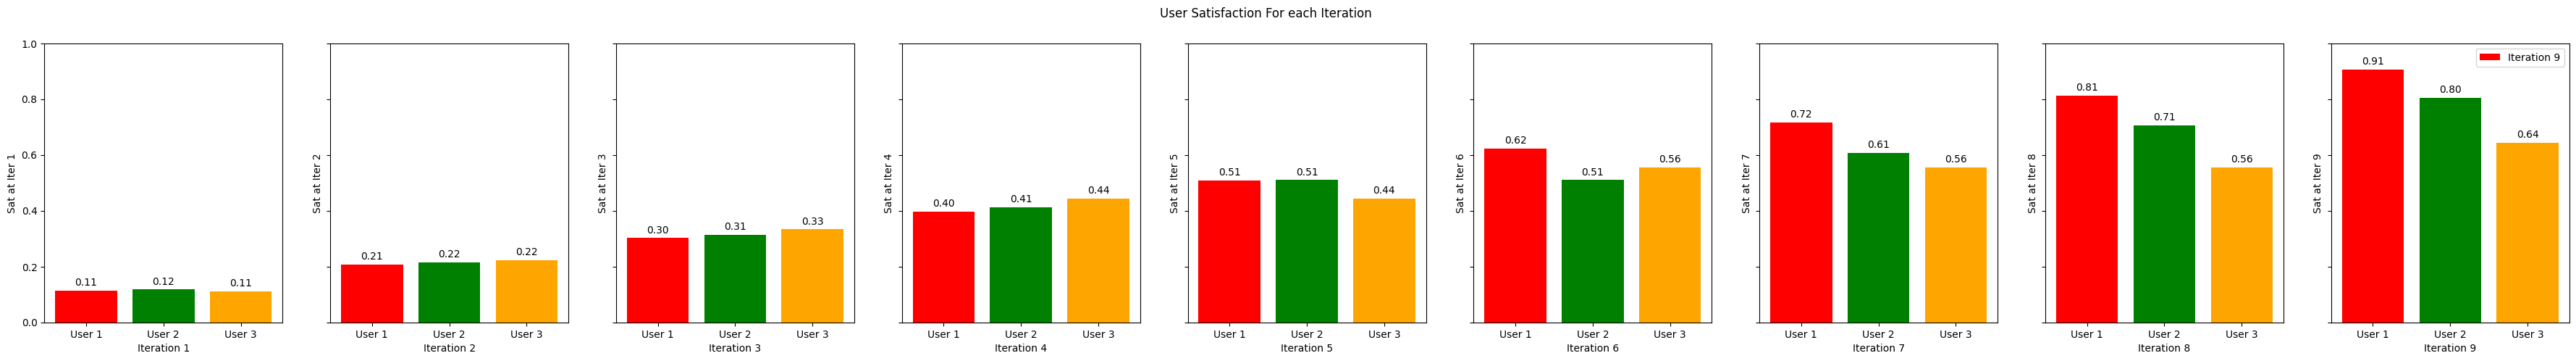

In [302]:
#visualising Results
import matplotlib.pyplot as plt
import numpy as np

# Example data with multiple iterations

# Number of iterations
num_iterations = len(allUserSatisfactions)

# Create subplots with multiple columns
fig, axs = plt.subplots(1, num_iterations, figsize=(5 * num_iterations, 5), sharey=True)

# Plot each iteration in a separate subplot
for i, (y_values, ax) in enumerate(zip(allUserSatisfactions, axs), start=1):
    # Colors for each bar within the subplot
    colors = ['red', 'green', 'orange']

    bars = ax.bar(np.arange(len(y_values)), y_values, color=colors, label=f'Iteration {i}')

    # Annotate each bar with its value
    for bar, value in zip(bars, y_values):
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(value),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Set bar names
    bar_names = ['User 1', 'User 2', 'User 3']  # Replace with your actual bar names
    ax.set_xticks(np.arange(len(y_values)))
    ax.set_xticklabels(bar_names)

    ax.set_ylabel(f'Sat at Iter {i}')
    ax.set_xlabel(f'Iteration {i}')
    ax.set_ylim(0, 1)

# Customize the plot
plt.suptitle('User Satisfaction For each Iteration')
plt.legend()

# Show the plot
plt.show()
